In [1]:
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import os
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import spacy
import  torchvision.models as models
import torchvision.transforms as transforms
spacy_eng = spacy.load("en_core_web_sm")
import torch.optim as optim
from tqdm.auto import tqdm

In [2]:
#!python3 -m spacy download en_core_web_lg
#!python3 -m spacy download en_core_web_sm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [3]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class CustomDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [5]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=128,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = CustomDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )

    return loader, dataset

In [6]:

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [9]:
loss_ = []
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder='PATH',
        annotation_file='PATH',
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = False

    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 30

    step = 0

    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
        loss_mean = []
        for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            imgs = imgs.to(device)
            captions = captions.to(device)
            
            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            loss_mean.append(loss.item())
            #writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        print(f'Epoch {epoch+1} - Loss{np.mean(loss_mean)}')
        loss_.append(np.mean(loss_mean)) 

In [29]:
#train()

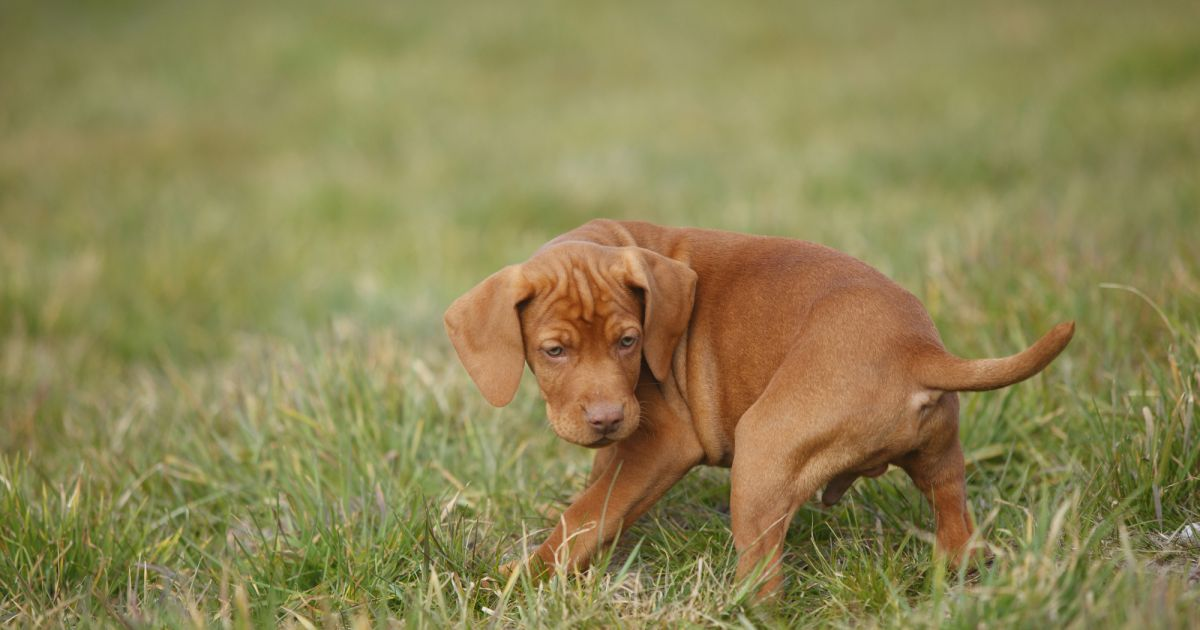

  a brown dog is running through the grass


In [56]:
from termcolor import colored

transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

test_img1 = Image.open("test/dog.jpg")
display(test_img1)

test_img1 = transform(Image.open("test/dog.jpg").convert("RGB")).unsqueeze(0)
description = model.caption_image(test_img1.to(device), dataset.vocab)
caption = ' '
for d in description[1:-2]:
    caption=caption+' '+colored(d, 'red')

print(caption)


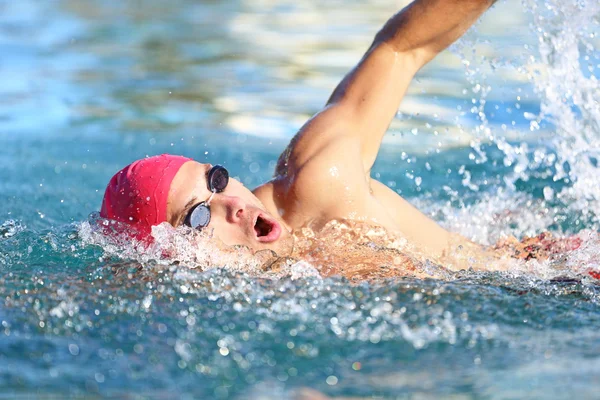

  a young girl in a pink bathing suit is jumping into a pool


In [57]:
test_img2 = Image.open("test/depositphotos_26346121-stock-photo-man-swimmer-swimming-crawl-in.jpg")
display(test_img2)

test_img2 = transform(Image.open("test/depositphotos_26346121-stock-photo-man-swimmer-swimming-crawl-in.jpg").convert("RGB")).unsqueeze(0)
description = model.caption_image(test_img2.to(device), dataset.vocab)
caption = ' '
for d in description[1:-2]:
    caption=caption+' '+colored(d, 'red')

print(caption)


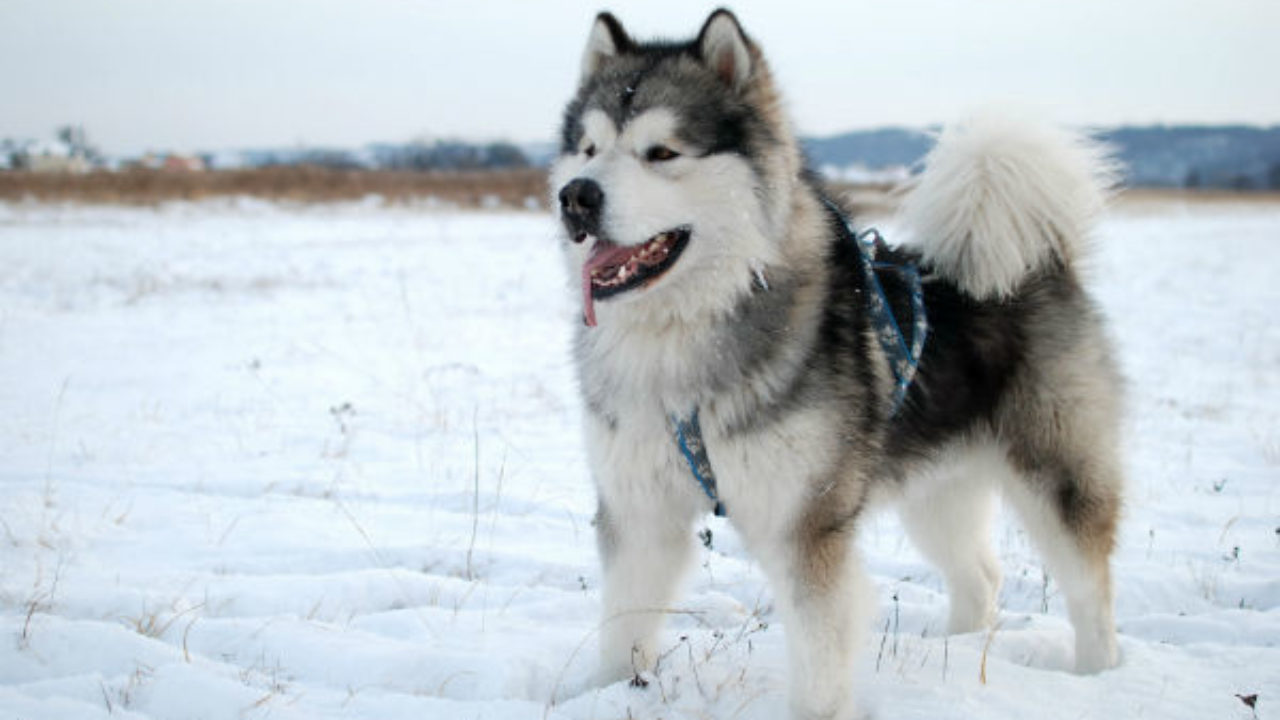

  a dog is running through the snow


In [58]:
test_img3 = Image.open("test/malamute.jpg")
display(test_img3)

test_img3 = transform(Image.open("test/malamute.jpg").convert("RGB")).unsqueeze(0)
description = model.caption_image(test_img3.to(device), dataset.vocab)
caption = ' '
for d in description[1:-2]:
    caption=caption+' '+colored(d, 'red')

print(caption)
